In [1]:
# Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import keras
import tensorflow as tf
from scipy import stats
import pandas as pd
import datetime, os
import numpy as np

/Users/abel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/abel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/abel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/abel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# Import the preprocessed file we made
print("File name: ") 
#file_name = input()

dataFrame = pd.read_csv(r'data/p/NSP_23_attributes.csv')
dataFrame.head()

File name: 


,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.813333,0.044118,0.472527,0.047337,...,0.110092,0.034483,0.111111,0.0,0.472441,0.587156,0.403670,0.271375,1.0,2
1,0.315789,0.0,0.400000,0.2,0.0,0.0,0.066667,0.279412,0.000000,0.205128,...,0.165138,0.655172,0.333333,0.1,0.637795,0.577982,0.577982,0.044610,0.5,1
2,0.157895,0.0,0.533333,0.2,0.0,0.0,0.053333,0.279412,0.000000,0.264300,...,0.165138,0.655172,0.277778,0.1,0.637795,0.568807,0.559633,0.048327,0.5,1
3,0.157895,0.0,0.533333,0.2,0.0,0.0,0.053333,0.323529,0.000000,0.453649,...,0.027523,0.413793,0.611111,0.0,0.606299,0.559633,0.550459,0.048327,1.0,1
4,0.368421,0.0,0.533333,0.0,0.0,0.0,0.053333,0.323529,0.000000,0.392505,...,0.027523,0.413793,0.500000,0.0,0.606299,0.577982,0.559633,0.040892,1.0,1


In [3]:
num_features = dataFrame.shape[1] - 1
print("We have " + str(num_features) + " features") 

We have 20 features


In [4]:
y = dataFrame.pop('NSP') - 1
X = np.array(dataFrame)
X

array([[0.        , 0.        , 0.        , ..., 0.40366972, 0.27137546,
        1.        ],
       [0.31578947, 0.        , 0.4       , ..., 0.57798165, 0.04460967,
        0.5       ],
       [0.15789474, 0.        , 0.53333333, ..., 0.55963303, 0.04832714,
        0.5       ],
       ...,
       [0.05263158, 0.        , 0.46666667, ..., 0.68807339, 0.01486989,
        1.        ],
       [0.05263158, 0.        , 0.4       , ..., 0.67889908, 0.01486989,
        1.        ],
       [0.10526316, 0.004158  , 0.53333333, ..., 0.62385321, 0.00371747,
        0.5       ]])

This model will be used for the NSP classification

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

# print(X.shape)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

# binary encode
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
# print(y_train.shape)
# y_train


from keras.regularizers import l1,l2

model = keras.Sequential([
    keras.layers.Dense(20, input_dim=num_features, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, 
                       activation='relu', 
                       kernel_regularizer=l2(0.01)),
    keras.layers.Dense(10, activation='relu', activity_regularizer=l1(0.01)),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax')
])


opt = keras.optimizers.RMSprop(learning_rate=0.0005, rho=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


# Tensorboard stuff
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

# Callbacks
tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)
earlystop_callback = EarlyStopping( monitor='val_loss', 
                                    min_delta=0.0001,
                                    mode='min',
                                    patience=5
                                  )

# Clear any logs from previous runs
#!rm -rf ./logs/ 

# Train the model
history = model.fit(x=X_train,
          y=y_train,
          epochs=1000,
          batch_size=50,
          validation_data=(X_val, y_val),
          callbacks=[earlystop_callback],
          verbose=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.


In [6]:
y_pred = model.predict_classes(X_test)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
# precision tp / (tp + fp)
precision = np.around(precision_score(y_test, y_pred, average=None), decimals=3)
# recall: tp / (tp + fn)
recall = np.around(recall_score(y_test, y_pred, average=None), decimals=3)
# f1: 2 tp / (2 tp + fp + fn)
f1 = np.around(f1_score(y_test, y_pred, average=None), decimals=3)

model.summary()
print("\n")
print("-"*18)
print('Accuracy: %f' % accuracy)
print("-"*40)
print("| Class:\t  N\t  S\t  P\t|")
print("| Precision:\t", precision[0], "\t", precision[1], "\t", precision[2], "\t|")
print("| Recall:\t", recall[0], "\t", recall[1], "\t", recall[2], "\t|")
print("| F1:\t\t", f1[0], "\t", f1[1], "\t", f1[2], "\t|")
print("-"*40)
#del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                420       
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1

In [7]:
# Load the TensorBoard notebook extension
#%reload_ext tensorboard
#%tensorboard --logdir logs/

In [8]:
#y_pred


In [9]:
#model.save('models/' + input() + '.h5')

# Shap/LIME analysis

In [10]:
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import shap #SHAP package
import matplotlib.pyplot as plt #for custom graphs at the end


In [11]:
modelExplainer = shap.DeepExplainer(model, X_train)

In [28]:
raw_shap_explanations = modelExplainer.shap_values(X_train)

In [29]:
print(len(raw_shap_explanations))
print(raw_shap_explanations[0].shape)
print(raw_shap_explanations[0][0].shape)

3
(1530, 20)
(20,)


In [25]:
print(raw_shap_explanations[0][0])

[-1.60998545e-02  3.68595798e-03  5.64688680e-02 -8.67365811e-03
 -6.22794690e-05  1.12734465e-02  4.92792495e-02  8.34624178e-03
  1.41343934e-02 -1.73265370e-03  6.17800741e-04  9.14988775e-03
  6.80352463e-03  5.78407978e-03 -1.96719255e-04  1.45359534e-02
  1.73254331e-02  1.11370659e-02  2.10850224e-02  2.04619422e-03]


In [27]:

number = np.sum(raw_shap_explanations[0][0])
print(number)

0.2049079539586417


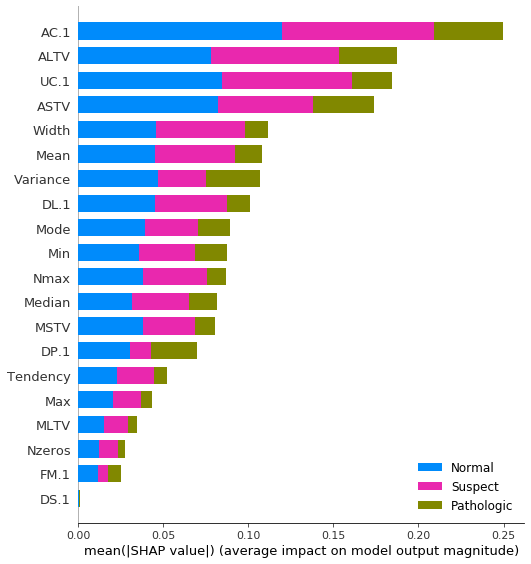

In [41]:
X_train = pd.DataFrame(X_train, columns=dataFrame.columns)

shap.summary_plot(raw_shap_explanations, X_train, plot_type="bar", class_names=['Normal', 'Suspect', 'Pathologic'])

Normal


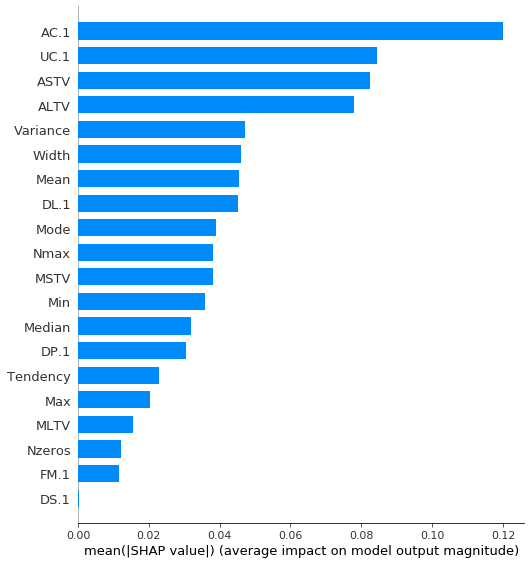

In [38]:
print("Normal")
shap.summary_plot(raw_shap_explanations[0], X_train, plot_type="bar")

Suspect


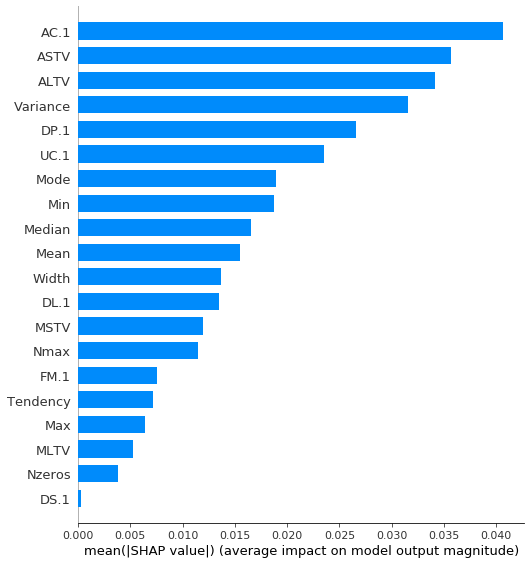

In [39]:
print("Suspect")
shap.summary_plot(raw_shap_explanations[2], X_train, plot_type="bar")

Pathologic


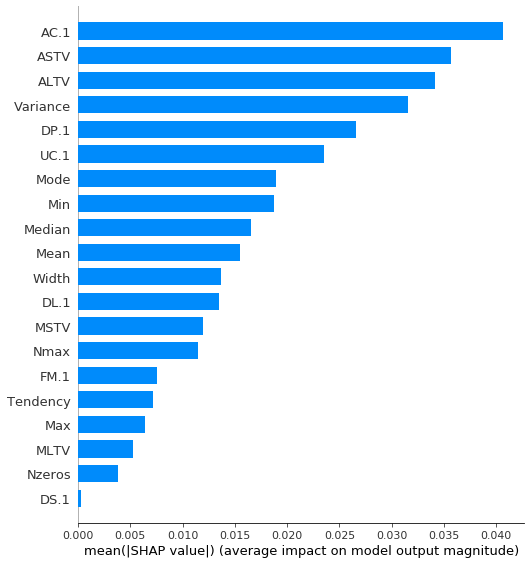

In [40]:
print("Pathologic")
shap.summary_plot(raw_shap_explanations[2], X_train, plot_type="bar")